In [1]:
###################################################
# Importing and reshaping the monkeys' data       #
# ----------------------------------------------- #
# Written by Ladislas Nalborczyk                  #
# E-mail: ladislas.nalborczyk@gmail.com           #
# Last updated on July 26, 2023                   #
###################################################

import os
from scipy.io import loadmat
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import animation
from math import *
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from matplotlib import cm
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
import mne
from mne.datasets import sample
from mne.decoding import (
    SlidingEstimator,
    GeneralizingEstimator,
    Scaler,
    cross_val_multiscore,
    LinearModel,
    get_coef,
    Vectorizer,
    CSP
    )

# Importing the data
## Step 1: getting the data

In [2]:
# importing spike trains
TS = loadmat("data/TS.mat")
TS = TS["TS"]

# importing other variables
df = pd.read_csv("data/spatial_task.csv")
df

,Filename,Neuron,Task,Training,Area,Cue_position,Cue_onT,Sample_onT,Target_onT,Reward_onT,trialnum,IsMatch
0,ADR001_1,3000,SPATIAL,PRE,dorsal,1,1.286575,3.320800,0.000000,5.354975,13,0.0
1,ADR001_1,3000,SPATIAL,PRE,dorsal,1,1.299075,3.333250,0.000000,5.367450,22,1.0
2,ADR001_1,3000,SPATIAL,PRE,dorsal,1,1.275575,3.309825,0.000000,5.343975,34,0.0
3,ADR001_1,3000,SPATIAL,PRE,dorsal,1,1.818300,3.852500,0.000000,5.886725,54,1.0
4,ADR001_1,3000,SPATIAL,PRE,dorsal,1,1.429975,3.464175,0.000000,5.498350,82,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...
284042,ELV182_1,2605,SPATIAL,POST,dorsal,9,1.059975,3.094175,5.128400,6.012050,136,0.0
284043,ELV182_1,2605,SPATIAL,POST,dorsal,9,1.065375,3.099600,5.133775,6.017525,148,0.0
284044,ELV182_1,2605,SPATIAL,POST,dorsal,9,1.074775,3.108975,5.143200,6.043625,157,1.0
284045,ELV182_1,2605,SPATIAL,POST,dorsal,9,1.065725,3.099950,5.134150,6.067875,183,0.0


## Step 2: reshaping it

In [3]:
# adding a column with the monkey's name (and converting to upper case)
df["monkey"] = df["Filename"].str[0:3].str.upper()
df

,Filename,Neuron,Task,Training,Area,Cue_position,Cue_onT,Sample_onT,Target_onT,Reward_onT,trialnum,IsMatch,monkey
0,ADR001_1,3000,SPATIAL,PRE,dorsal,1,1.286575,3.320800,0.000000,5.354975,13,0.0,ADR
1,ADR001_1,3000,SPATIAL,PRE,dorsal,1,1.299075,3.333250,0.000000,5.367450,22,1.0,ADR
2,ADR001_1,3000,SPATIAL,PRE,dorsal,1,1.275575,3.309825,0.000000,5.343975,34,0.0,ADR
3,ADR001_1,3000,SPATIAL,PRE,dorsal,1,1.818300,3.852500,0.000000,5.886725,54,1.0,ADR
4,ADR001_1,3000,SPATIAL,PRE,dorsal,1,1.429975,3.464175,0.000000,5.498350,82,1.0,ADR
...,...,...,...,...,...,...,...,...,...,...,...,...,...
284042,ELV182_1,2605,SPATIAL,POST,dorsal,9,1.059975,3.094175,5.128400,6.012050,136,0.0,ELV
284043,ELV182_1,2605,SPATIAL,POST,dorsal,9,1.065375,3.099600,5.133775,6.017525,148,0.0,ELV
284044,ELV182_1,2605,SPATIAL,POST,dorsal,9,1.074775,3.108975,5.143200,6.043625,157,1.0,ELV
284045,ELV182_1,2605,SPATIAL,POST,dorsal,9,1.065725,3.099950,5.134150,6.067875,183,0.0,ELV


In [6]:
# converting dataframe to numpy arrays
training = df.Training.to_numpy()
area = df.Area.to_numpy()
cue = df.Cue_position.to_numpy()
neuronID = df.Neuron.to_numpy()
monkey = df.monkey.to_numpy()
reward = df.Reward_onT.to_numpy()

# extract neurons of interst
elv_monkey = monkey == "ELV"
postTrainTrials = training == "POST"
dorsalNeuron = area == "dorsal"
ventralNeuron = area == "ventral"
cuePosition = cue == 1
reward_not_nan = np.isnan(reward) == False

# lines of interest in the data (focusing on post-training data and the ELV monkey)
# left cues: 4-5-6
# right cues: 2-1-8
# NOI = postTrainTrials & dorsalNeuron & cuePosition & elv_monkey
# NOI = postTrainTrials & dorsalNeuron & elv_monkey
NOI = postTrainTrials & elv_monkey & reward_not_nan & cuePosition

# filtering the data
TS_NOI = TS[NOI]

# filtering neurons
neuronID_NOI = np.unique(neuronID[NOI])
neuronNum = len(np.unique(neuronID_NOI) )

# excluding trials without reward
# np.isnan()

# number of available lines (neurons * trials)
print(TS_NOI.shape)

# number of available neurons
print("Number of available neurons:", neuronID_NOI.shape[0])

(11636, 1)
Number of available neurons: 798


In [7]:
# filtering df to correspond to TS_NOI
# df_NOI = df.query('monkey == "ELV" & Training == "POST" & Cue_position == 1 & Area == "dorsal"')
df_NOI = df.query('monkey == "ELV" & Training == "POST" & Cue_position == 1')
# df_NOI = df.query('monkey == "ELV" & Training == "POST" & Area == "dorsal"')
# df_NOI = df.query('monkey == "ELV" & Training == "POST"')

# excluding trials without reward
df_NOI = df_NOI.dropna(subset = ["Reward_onT"])

# printing the DF shape and number of unique neurons
print(df_NOI.shape, len(np.unique(df_NOI.Neuron) ) )

# displaying the first ten rows
df_NOI.head(10)

(11636, 13) 798


,Filename,Neuron,Task,Training,Area,Cue_position,Cue_onT,Sample_onT,Target_onT,Reward_onT,trialnum,IsMatch,monkey
179081,ELV088_1,2001,SPATIAL,POST,dorsal,1,1.059950,3.094175,5.128350,0.0,13,0.0,ELV
179082,ELV088_1,2001,SPATIAL,POST,dorsal,1,1.062900,3.097125,5.131300,0.0,25,1.0,ELV
179083,ELV088_1,2001,SPATIAL,POST,dorsal,1,1.069300,3.103500,5.137725,0.0,27,1.0,ELV
179084,ELV088_1,2001,SPATIAL,POST,dorsal,1,1.059275,3.093475,5.127700,0.0,37,0.0,ELV
179085,ELV088_1,2001,SPATIAL,POST,dorsal,1,1.065825,3.100025,5.134200,0.0,49,1.0,ELV
179086,ELV088_1,2001,SPATIAL,POST,dorsal,1,1.069125,3.086675,5.120850,0.0,57,0.0,ELV
179087,ELV088_1,2001,SPATIAL,POST,dorsal,1,1.074025,3.108225,5.142400,0.0,74,0.0,ELV
179088,ELV088_1,2001,SPATIAL,POST,dorsal,1,1.054450,3.088625,5.122825,0.0,92,1.0,ELV
179089,ELV088_1,2001,SPATIAL,POST,dorsal,1,1.055900,3.090125,5.124350,0.0,98,1.0,ELV
179090,ELV088_1,2001,SPATIAL,POST,dorsal,1,1.056275,3.090450,5.124675,0.0,102,0.0,ELV


In [6]:
# find ranges of Cue_onT and Target_onT values
cue_range = df.query('monkey == "ELV" & Training == "POST" & Cue_position == 1 & Area == "dorsal"')["Cue_onT"]
target_range = df.query('monkey == "ELV" & Training == "POST" & Cue_position == 1 & Area == "dorsal"')["Target_onT"]
print("Min and Max values for Cue_onT", np.min(cue_range), np.max(cue_range) )
print("Min and Max values for Target_onT", np.min(target_range), np.max(target_range) )
print("Min and Max values for Target_onT - Cue_onT", np.min(target_range - cue_range), np.max(target_range - cue_range) )

Min and Max values for Cue_onT 1.047425 2.1509
Min and Max values for Target_onT 5.1135 6.219325
Min and Max values for Target_onT - Cue_onT 4.0516 4.068575


In [8]:
def spike_times_to_spike_trains(spiking_times, time_step = 0.01, start_cue = 0, start_target = 0):
    
    # converting max time to wanted time resolution and add 1 for inclusive range
    max_time = int((start_target - start_cue) * 1 / time_step) + 1
    spike_train = [0] * max_time
    
    # removing spikes outside the period of interest (i.e., between Cue_onT and Target_onT)
    spiking_times = [i for i in spiking_times if i > start_cue and i < start_target]
    
    # removing offset from spiking_times
    spiking_times = [x - start_cue for x in spiking_times]
    
    for time in spiking_times:
        
        dt = int(time * 1 / time_step)
        spike_train[dt] = 1
    
    return spike_train

# example usage
# spiking_times = [0.46, 1.42, 3.7834, 4.89, 7.32]
spiking_times = [3.819625, 3.9098, 5.0566, 6.224475]
binary_series = spike_times_to_spike_trains(spiking_times = spiking_times, start_cue = 1, start_target = 6)
print("Number of time steps:", len(binary_series), "\nNumber of spikes:", np.sum(binary_series) )
print(binary_series)

Number of time steps: 501 
Number of spikes: 3
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0

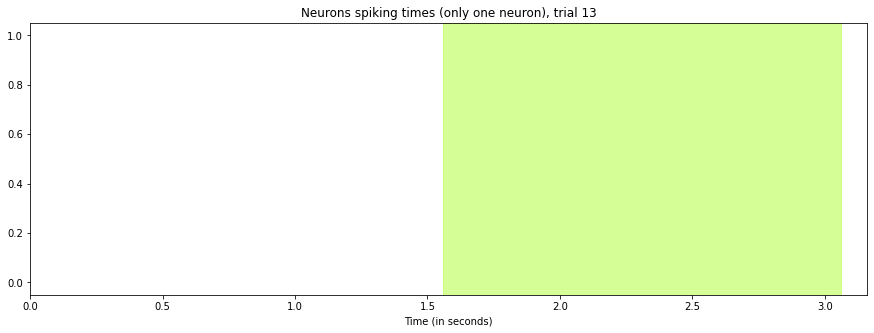

In [9]:
# plotting one spike train (in one trial)
trialnum = df["trialnum"].to_numpy()[NOI][0]
start_delay = df["Cue_onT"].to_numpy()[NOI][0] + 0.5
start_delay2 = df["Sample_onT"].to_numpy()[NOI][0] + 0.5
delay_duration = 1.5

# define light offset time
end_delay = start_delay + delay_duration
end_delay2 = start_delay2 + delay_duration

fig, ax = plt.subplots(figsize = (15, 5) )
ax.vlines(spiking_times, 0, 1)

# set x axis range and label
ax.set_xlim([0, end_delay + 0.1])
ax.set_xlabel("Time (in seconds)")
# ax.set_ylabel("Neuron firing")

# add title to plot
ax.set_title("Neurons spiking times (only one neuron), trial " + str(trialnum) )

# add shading for stimulus duration
ax.axvspan(start_delay, end_delay, alpha = 0.5, color = "greenyellow")

# add shading for stimulus duration
# ax.axvspan(start_delay, end_delay, alpha = 0.5, color = "greenyellow")

# fig=plt.figure(figsize=(15, 15))

plt.show()

In [10]:
# find all trials of first neuron
neuron_2001_rows = df_NOI.index.get_indexer(df_NOI.query("Neuron == 2001").index)
print("Number of available trials for this neuron:", len(neuron_2001_rows) )
print("Trials:", neuron_2001_rows)

Number of available trials for this neuron: 20
Trials: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19]


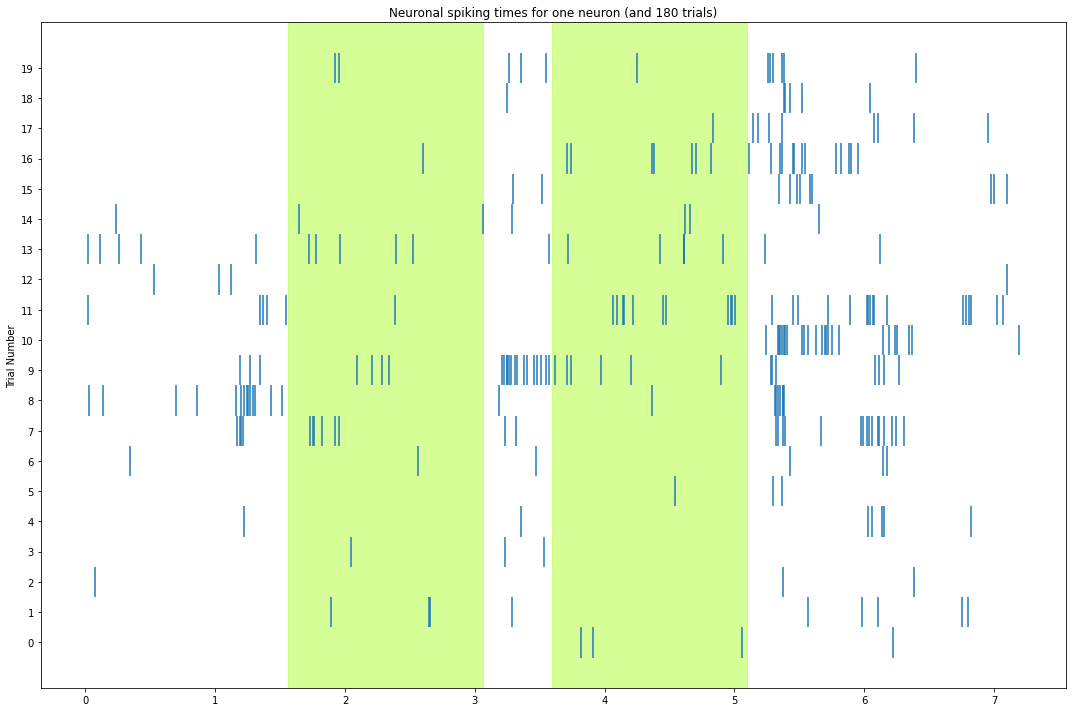

In [11]:
# plotting these trials
# from https://neuraldatascience.io/6-single_unit/intro_spike_trains.html
ten_spike_times = TS_NOI[neuron_2001_rows]

# plotting one spike train (in one trial)
trialnum = df["trialnum"].to_numpy()[NOI][0]
start_delay = df["Cue_onT"].to_numpy()[NOI][0] + 0.5
start_delay2 = df["Sample_onT"].to_numpy()[NOI][0] + 0.5
delay_duration = 1.5

# define light offset time
end_delay = start_delay + delay_duration
end_delay2 = start_delay2 + delay_duration

# start_delay = df["Sample_onT"].to_numpy()[NOI][0] + 0.5
# delay_duration = 1.5
# start_delay2 = start_delay + delay_duration + 0.5
# delay_duration = 1.5

# define light offset time
# end_delay = start_delay + delay_duration
# end_delay2 = start_delay2 + delay_duration

# fig, axs = plt.subplots(2, 1, figsize=[10,5])
fig, ax = plt.subplots(figsize = [15, 10])

########################################
# draw raster into first subplot, axs[0]
# add shading for stimulus duration)
# axs[0].axvspan(light_onset_time, light_offset_time, alpha=0.5, color='greenyellow')
# add shading for stimulus duration
ax.axvspan(start_delay, end_delay, alpha = 0.5, color = "greenyellow")
ax.axvspan(start_delay2, end_delay2, alpha = 0.5, color = "greenyellow")

for trial in range(len(ten_spike_times)):
    # spike_times = [i for i, x in enumerate(ten_spike_trains[trial]) if x == spike_value]
    spike_times = ten_spike_times[trial][0][0]
    ax.vlines(spike_times, trial - 0.5, trial + 0.5)

# Set x axis range so that time zero is more visible    
# ax.set_xlim([-1, len(spike_train)])

# specify tick marks and label label y axis
ax.set_yticks(range(len(ten_spike_times) ) )
ax.set_ylabel("Trial Number")
ax.set_title("Neuronal spiking times for one neuron (and 180 trials)")

# overall figure stuff
plt.locator_params(axis = "y", nbins = 20)
plt.tight_layout()
plt.savefig(fname = "figures/one_neuron_spiking_trains.png", dpi = 200)
plt.show()

In [12]:
# smoothing spike trains (gaussian kernel)
def gaussian_kernel(x, sigma = 1.0):
    
    return np.exp(-(x ** 2) / (2 * sigma ** 2)) / (sigma * np.sqrt(2 * np.pi))

def kernel_smooth_spike_data(spike_times, time_range, kernel_sigma = 0.1, num_points = 1000):
    
    # num_points = len(spike_times)
    time_points = np.linspace(time_range[0], time_range[1], num_points)
    smoothed_signal = np.zeros_like(time_points)

    for spike_time in spike_times:
        kernel = gaussian_kernel(time_points - spike_time, sigma = kernel_sigma)
        smoothed_signal += kernel

    return smoothed_signal

# sample spike data (replace this with your actual spike data)
spike_times = [1.5, 2.7, 3.2, 4.5, 5.0]
# spike_times = [i for i, x in enumerate(all_neurons[0,:]) if x != 0]
print("Spike times:", spike_times)
print("Length of spike times:", len(spike_times) )

# defining the time range for kernel smoothing
time_range = [0, 10]
# time_range = [0, len(all_neurons[0,:])]

# smootingh the spike data
smoothed_signal = kernel_smooth_spike_data(spike_times, time_range)
print("Length of smoothed signal:", len(smoothed_signal) )

Spike times: [1.5, 2.7, 3.2, 4.5, 5.0]
Length of spike times: 5
Length of smoothed signal: 1000


In [13]:
####################################################################################
# retrieving all trials for all neurons and averaging across trials
# general average plus averge per trial type (matching vs. non-matching)
#############################################################################

# listing all neurons for ELV
elv_neurons = np.unique(df_NOI["Neuron"].to_numpy() )

# initialising the neurons array
max_time_steps = 410
all_neurons = np.empty((len(elv_neurons), max_time_steps) )

# initialising the matching and non-matching arrays
matching_trials = np.empty((len(elv_neurons), max_time_steps) )
non_matching_trials = np.empty((len(elv_neurons), max_time_steps) )

# initialising the row counter
neuron_row = 0
    
for neuron in elv_neurons:
    
    # printing neuron progress
    print("Processing neuron:", neuron)
    
    # finding all trials for this neuron
    # WARNING: some (few) trials are duplicated and should be then removed
    df_neuron = df_NOI.query("Neuron == " + str(neuron) )
    df_neuron = df_neuron.drop_duplicates(subset = "trialnum", keep = "first")
    neuron_rows = df_NOI.index.get_indexer(df_neuron.index)
    
    # printing number of trials for this particular neuron
    print("Number of available trials:", len(neuron_rows) )
    
    # retrieving all trials for this neuron
    spike_times = TS_NOI[neuron_rows]
    
    # initialising empty list for trials
    spike_trains = np.empty((spike_times.shape[0], max_time_steps) )
    
    # checking the shape of spike_trains
    # print(spike_trains.shape)
    
    for trial in range(spike_times.shape[0]):
        
        # printing trial progress
        # print("Trial: ", trial)
        
        # if there is no spike in this trial
        if np.sum(spike_times[trial][0]) == 0:
            
            spike_train = [0] * max_time_steps
            
        else: 
        
            # retrieving spiking times for this trial
            this_trial_spikes_train = spike_times[trial][0][0]
            
            # retrieving the trials numbers
            this_neuron_trialnum = np.unique(df_neuron["trialnum"].to_numpy() )
            this_trial_start_cue = np.round(df_neuron.query("trialnum == " + str(this_neuron_trialnum[trial]) )["Cue_onT"].to_numpy()[0], 3)
            this_trial_start_target = np.round(df_neuron.query("trialnum == " + str(this_neuron_trialnum[trial]) )["Target_onT"].to_numpy()[0], 3)
            spike_train = np.array(spike_times_to_spike_trains(this_trial_spikes_train, start_cue = this_trial_start_cue, start_target = this_trial_start_target) )
            if spike_train.shape[0] < 410: spike_train.resize(410, refcheck = False)
            
            # retrieving the match/non-match status for this neuron and for this trial
            this_neuron_match = df_neuron["IsMatch"].to_numpy()
            this_trial_match = df_neuron.query("trialnum == " + str(this_neuron_trialnum[trial]) )["IsMatch"].to_numpy()[0]
        
        # np.append(spike_trains, spike_train, axis = 0)
        # np.vstack((spike_trains, spike_train) )
        # spike_trains[trial, :] = spike_train
        
        # smoothing the spike trains per trial before averaging
        smoothed_spike_train = kernel_smooth_spike_data(this_trial_spikes_train, time_range = [np.min(this_trial_spikes_train), np.max(this_trial_spikes_train)], num_points = max_time_steps)
        spike_trains[trial, :] = smoothed_spike_train
    
    # print(spike_trains[0])
    # print(type(spike_train))
    # print(len(spike_trains) )
    # spike_trains = np.array(spike_trains)
    print("Shape of spiking times array (trial x time steps)", spike_trains.shape)
    
    # averaging these data
    averaged_neuron_spikes = np.mean(spike_trains, axis = 0)
    averaged_neuron_spikes_matching = np.mean(spike_trains[this_neuron_match == 1, :], axis = 0)
    averaged_neuron_spikes_non_matching = np.mean(spike_trains[this_neuron_match == 0, :], axis = 0)
    
    # appending data
    # all_neurons.append(averaged_neuron_spikes)
    # np.vstack((all_neurons, averaged_neuron_spikes) )
    all_neurons[neuron_row, :] = averaged_neuron_spikes
    matching_trials[neuron_row, :] = averaged_neuron_spikes_matching
    non_matching_trials[neuron_row, :] = averaged_neuron_spikes_non_matching
    
    # incrementing the row counter
    neuron_row += 1

Processing neuron: 2001
Number of available trials: 20
Shape of spiking times array (trial x time steps) (20, 410)
Processing neuron: 2002
Number of available trials: 20
Shape of spiking times array (trial x time steps) (20, 410)
Processing neuron: 2003
Number of available trials: 20
Shape of spiking times array (trial x time steps) (20, 410)
Processing neuron: 2004
Number of available trials: 20
Shape of spiking times array (trial x time steps) (20, 410)
Processing neuron: 2006
Number of available trials: 20
Shape of spiking times array (trial x time steps) (20, 410)
Processing neuron: 2007
Number of available trials: 20
Shape of spiking times array (trial x time steps) (20, 410)
Processing neuron: 2008
Number of available trials: 20
Shape of spiking times array (trial x time steps) (20, 410)
Processing neuron: 2011
Number of available trials: 20
Shape of spiking times array (trial x time steps) (20, 410)
Processing neuron: 2012
Number of available trials: 20
Shape of spiking times ar

In [14]:
# some sanity checks
print(all_neurons.shape, matching_trials.shape, non_matching_trials.shape)
print(all_neurons[0])

# exporting these numpy arrays
np.save("all_neurons.npy", all_neurons)
np.save("matching_trials.npy", matching_trials)
np.save("non_matching_trials.npy", non_matching_trials)

(798, 410) (798, 410) (798, 410)
[6.00325026 6.11746425 6.17084627 6.16477925 6.10345715 5.99338354
 5.84270456 5.66047156 5.45592658 5.23788716 5.01428114 4.79185258
 4.57603373 4.37095726 4.17957102 4.00381336 3.84480952 3.70305695
 3.57857768 3.47102695 3.37975834 3.30385412 3.24213612 3.19317436
 3.1553097  3.12670177 3.10540675 3.08948122 3.07710183 3.06668529
 3.05699191 3.04719802 3.03692665 3.02623298 3.01554681 3.00558031
 2.99721267 2.99136512 2.98887954 2.99041253 2.99635483 3.00678306
 3.02144802 3.03980017 3.06104891 3.08424836 3.10839842 3.13254743
 3.15588195 3.17779048 3.19789211 3.21602613 3.23220559 3.24654357
 3.25916611 3.27012833 3.27935023 3.2865862  3.29143725 3.29340865
 3.2920084  3.28687503 3.27791737 3.26544453 3.25026292 3.23371837
 3.21766643 3.20436259 3.19627611 3.19584508 3.2052039  3.22592472
 3.25881806 3.3038323  3.36007621 3.42596527 3.49946553 3.57838501
 3.66064886 3.74449588 3.82855166 3.91176401 3.99322219 4.07191252
 4.14648146 4.21507629 4.2753

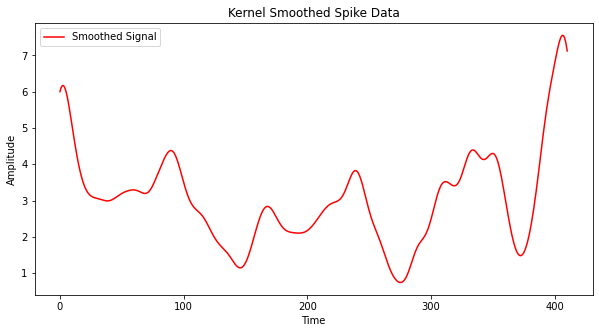

In [15]:
# plotting one averaged smoothed spike train (for one neuron)
plt.figure(figsize = (10, 5) )
plt.plot(np.linspace(0, len(all_neurons[0, :]), len(all_neurons[0, :]) ), all_neurons[0, :], "r-")
plt.xlabel("Time")
plt.ylabel("Amplitude")
plt.title("Kernel Smoothed Spike Data")
plt.legend(["Smoothed Signal", "Spike Data"])
plt.show()

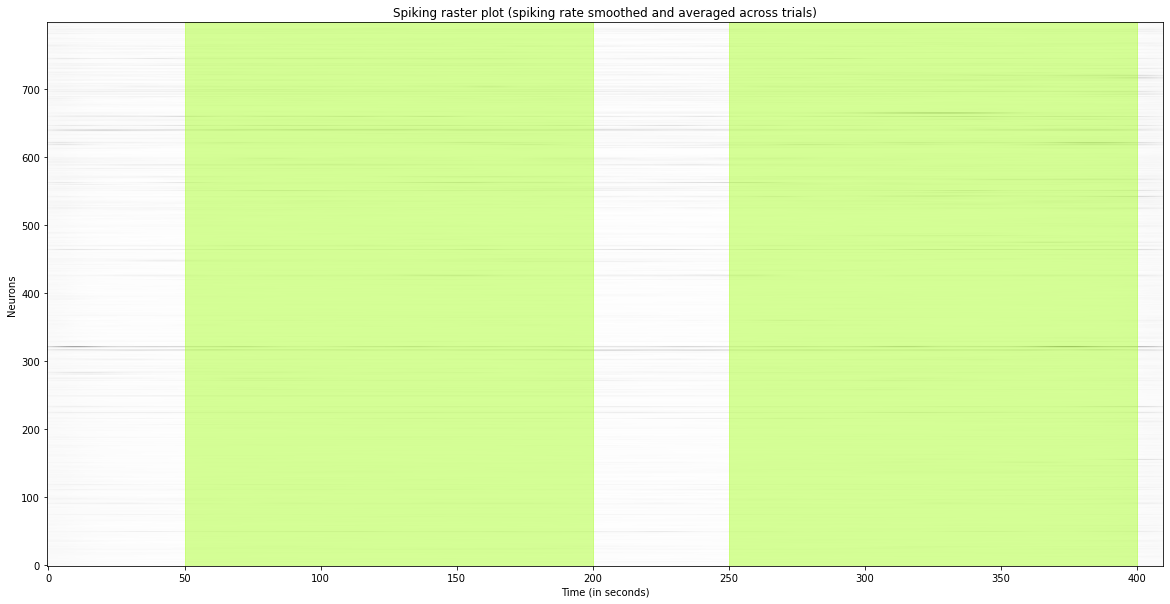

In [16]:
# spiking raster plot
start_first_delay = 0.5 / 0.01
end_first_delay = (0.5 + 1.5) / 0.01
start_second_delay = 2.5 / 0.01
end_second_delay = (2.5 + 1.5) / 0.01
fig, ax = plt.subplots(figsize = [20, 10])
plt.imshow(all_neurons, cmap = "Greys", origin = "lower", aspect = "auto")
ax.axvspan(start_first_delay, end_first_delay, alpha = 0.5, color = "greenyellow")
ax.axvspan(start_second_delay, end_second_delay, alpha = 0.5, color = "greenyellow")
plt.title("Spiking raster plot (spiking rate smoothed and averaged across trials)")
plt.xlabel("Time (in seconds)")
plt.ylabel("Neurons")
plt.show()

# Dimension reduction
## Step 1: Smoothing spike trains (already performed above, only for visualisation purposes below)

Spike times: [1.5, 2.7, 3.2, 4.5, 5.0]


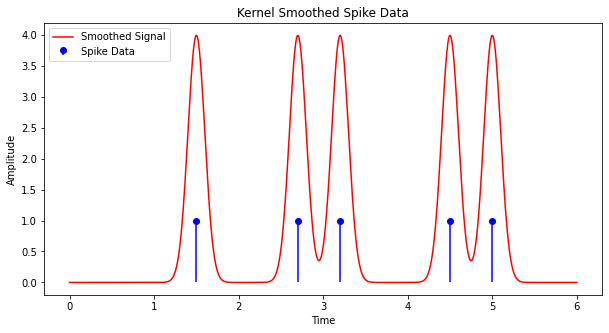

In [17]:
# smoothing spike trains (gaussian kernel)
def gaussian_kernel(x, sigma = 1.0):
    
    return np.exp(-(x ** 2) / (2 * sigma ** 2)) / (sigma * np.sqrt(2 * np.pi))

def kernel_smooth_spike_data(spike_times, time_range, kernel_sigma = 0.1, num_points = 1000):
    
    # num_points = len(spike_times)
    time_points = np.linspace(time_range[0], time_range[1], num_points)
    smoothed_signal = np.zeros_like(time_points)

    for spike_time in spike_times:
        kernel = gaussian_kernel(time_points - spike_time, sigma = kernel_sigma)
        smoothed_signal += kernel

    return smoothed_signal

# sample spike data (replace this with your actual spike data)
spike_times = [1.5, 2.7, 3.2, 4.5, 5.0]
# spike_times = [i for i, x in enumerate(all_neurons[0,:]) if x != 0]
print("Spike times:", spike_times)
# print(len(all_neurons[0,:]) )

# defining the time range for kernel smoothing
time_range = [0, 6]
# time_range = [0, len(all_neurons[0,:])]

# smootingh the spike data
smoothed_signal = kernel_smooth_spike_data(spike_times, time_range)

# plotting the original spike data and the smoothed signal
plt.figure(figsize = (10, 5) )
plt.stem(spike_times, np.ones_like(spike_times), linefmt = 'b-', markerfmt = 'bo', basefmt = ' ')
plt.plot(np.linspace(time_range[0], time_range[1], len(smoothed_signal) ), smoothed_signal, 'r-')
plt.xlabel('Time')
plt.ylabel('Amplitude')
plt.title('Kernel Smoothed Spike Data')
plt.legend(['Smoothed Signal', 'Spike Data'])
plt.show()

## Step 2: Computing PCA (through time to get trajectories/dynamics)

In [18]:
# computing PCA
pca = PCA(n_components = 10)
x_pca = pca.fit_transform(np.transpose(all_neurons) )

# some checks
print("Shape of PCA object:", x_pca.shape)
print("3 first components explain around:", np.round(np.sum(pca.explained_variance_ratio_[0:2]), 2) * 100, "% of the variance.")
print("PCA eigenvalues:", pca.singular_values_)

Shape of PCA object: (410, 10)
3 first components explain around: 50.0 % of the variance.
PCA eigenvalues: [875.36213857 649.94825218 464.10152596 430.22743534 368.5676133
 331.95571357 305.13755355 266.42319449 254.1329566  222.79213036]


In [19]:
# trying out t-SNE instead?
# !pip install threadpoolctl==3.1.0
tsne = TSNE(n_components = 2, perplexity = 100)
x_tsne = tsne.fit_transform(np.transpose(all_neurons) )
print("Shape of tSNE object:", x_tsne.shape)

Shape of tSNE object: (410, 2)


In [20]:
# assigning colours to timepoints
timepoints = np.arange(all_neurons.shape[1])
colormap = cm.get_cmap("cool")
norm = plt.Normalize(vmin = timepoints.min(), vmax = timepoints.max() )

/var/folders/yp/p14xyqpj5l3bnhqhhfk5qhqr0000gn/T/ipykernel_67529/3242889701.py:3: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colormap = cm.get_cmap("cool")


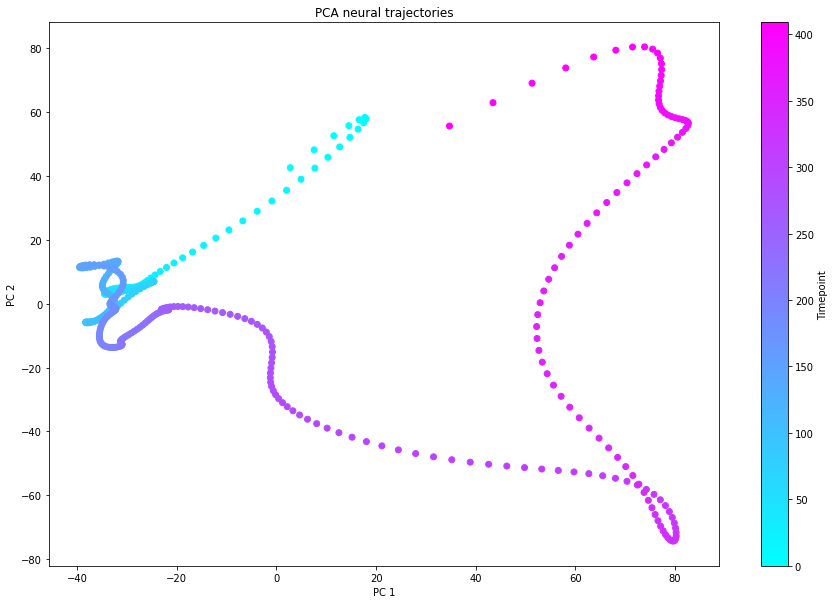

In [21]:
# 2D plot
# see coloured lines at https://matplotlib.org/stable/gallery/lines_bars_and_markers/multicolored_line.html
fig = plt.figure(figsize = (15, 10) )
scatter = plt.scatter(x_pca[:,0], x_pca[:,1], c = timepoints, cmap = colormap, norm = norm)
# line = plt.plot(x_pca[:, 0], x_pca[:, 1], lw = 1, c = "black", alpha = 0.2)[0]
plt.colorbar(scatter, label = "Timepoint")
plt.xlabel("PC 1")
plt.ylabel("PC 2")
plt.title("PCA neural trajectories")
plt.show()

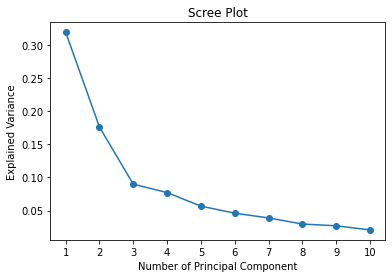

In [22]:
# scree plot
explained_variance_ratio = pca.explained_variance_ratio_

x_range = [x for x in range(0, len(explained_variance_ratio))]
x_range_labels = [x+1 for x in range(0, len(explained_variance_ratio))]
plt.plot(x_range, explained_variance_ratio, marker = "o")
plt.xticks(ticks = x_range,labels = x_range_labels)
plt.xlabel("Number of Principal Component")
plt.ylabel("Explained Variance")
plt.title("Scree Plot")
plt.show()

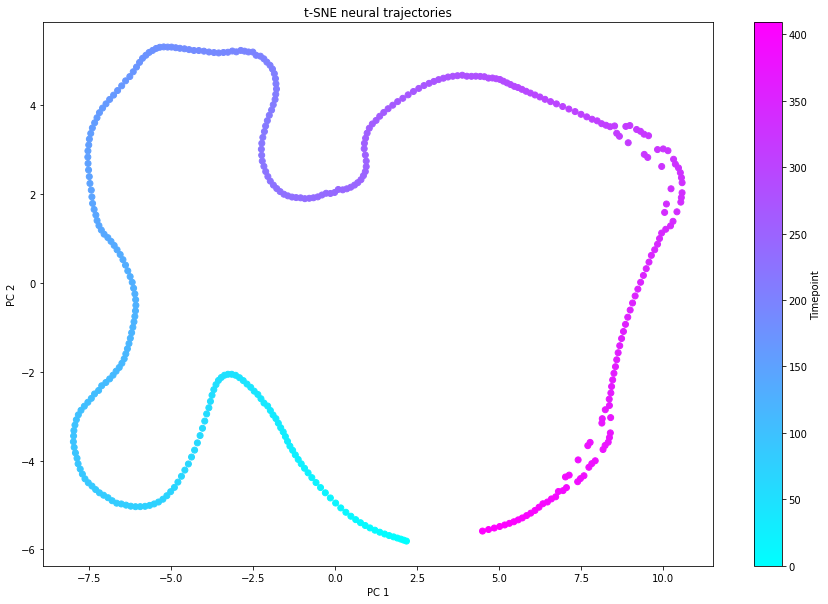

In [23]:
# 2D plot
# see coloured lines at https://matplotlib.org/stable/gallery/lines_bars_and_markers/multicolored_line.html
fig = plt.figure(figsize = (15, 10) )
scatter = plt.scatter(x_tsne[:,0], x_tsne[:,1], c = timepoints, cmap = colormap, norm = norm)
# line = plt.plot(x_pca[:, 0], x_pca[:, 1], lw = 1, c = "black", alpha = 0.2)[0]
plt.colorbar(scatter, label = "Timepoint")
plt.xlabel("PC 1")
plt.ylabel("PC 2")
plt.title("t-SNE neural trajectories")
plt.show()

Start cue (red): 2.788 42.59 -3.312
Start first delay (blue): -33.795 3.113 -19.755
Start sample (green): -34.129 -13.458 13.693
Start second delay (orange): -22.66 -1.903 37.978


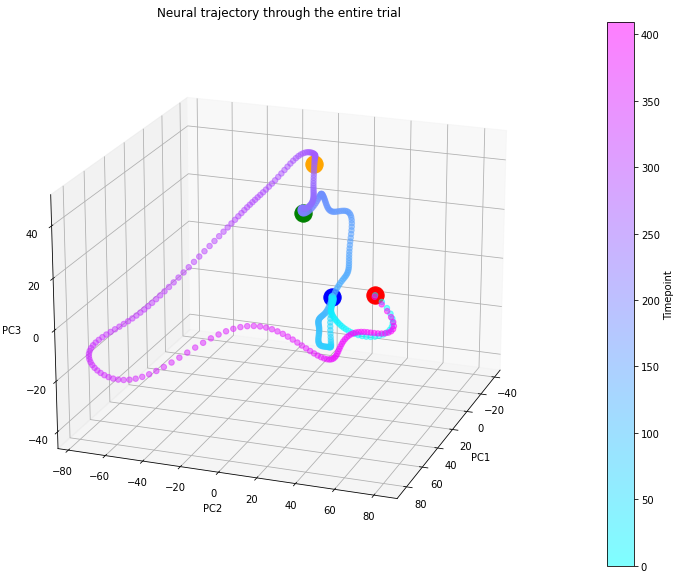

In [24]:
# 3D plot
# see also https://scikit-learn.org/stable/auto_examples/decomposition/plot_pca_iris.html#sphx-glr-auto-examples-decomposition-plot-pca-iris-py
from mpl_toolkits import mplot3d

fig = plt.figure(figsize = (20, 10) )
ax = plt.axes(projection = "3d")

sc = ax.scatter(x_pca[:, 0], x_pca[:, 1], x_pca[:, 2], c = timepoints, cmap = colormap, s = 30, alpha = 0.5)
# line = plt.plot(x_pca[:, 0], x_pca[:, 1], x_pca[:, 2], lw = 1, c = "black", alpha = 0.2)[0]

################################################################################
# plotting markers for periods changes within the trial
########################################################################

time_point = 0
ax.scatter(x_pca[time_point, 0], x_pca[time_point, 1], x_pca[time_point, 2], marker = "o", s = 300, c = "red")
print("Start cue (red):", round(x_pca[time_point, 0], 3), round(x_pca[time_point, 1], 3), round(x_pca[time_point, 2], 3) )

time_point = int(0.5 / 0.01)
ax.scatter(x_pca[time_point, 0], x_pca[time_point, 1], x_pca[time_point, 2], marker = "o", s = 300, c = "blue")
print("Start first delay (blue):", round(x_pca[time_point, 0], 3), round(x_pca[time_point, 1], 3), round(x_pca[time_point, 2], 3) )

time_point = int(2 / 0.01)
ax.scatter(x_pca[time_point, 0], x_pca[time_point, 1], x_pca[time_point, 2], marker = "o", s = 300, c = "green")
print("Start sample (green):", round(x_pca[time_point, 0], 3), round(x_pca[time_point, 1], 3), round(x_pca[time_point, 2], 3) )

time_point = int(2.5 / 0.01)
ax.scatter(x_pca[time_point, 0], x_pca[time_point, 1], x_pca[time_point, 2], marker = "o", s = 300, c = "orange")
print("Start second delay (orange):", round(x_pca[time_point, 0], 3), round(x_pca[time_point, 1], 3), round(x_pca[time_point, 2], 3) )

ax.view_init(20, 20, 0)
plt.colorbar(sc, label = "Timepoint")

ax.set_xlabel("PC1")
ax.set_ylabel("PC2")
ax.set_zlabel("PC3")
ax.set_title("Neural trajectory through the entire trial")

plt.show()

Shape of pca_global object: (410, 10)
Shape of pca_matching object: (410, 10)
Shape of pca_non_matching object: (410, 10)


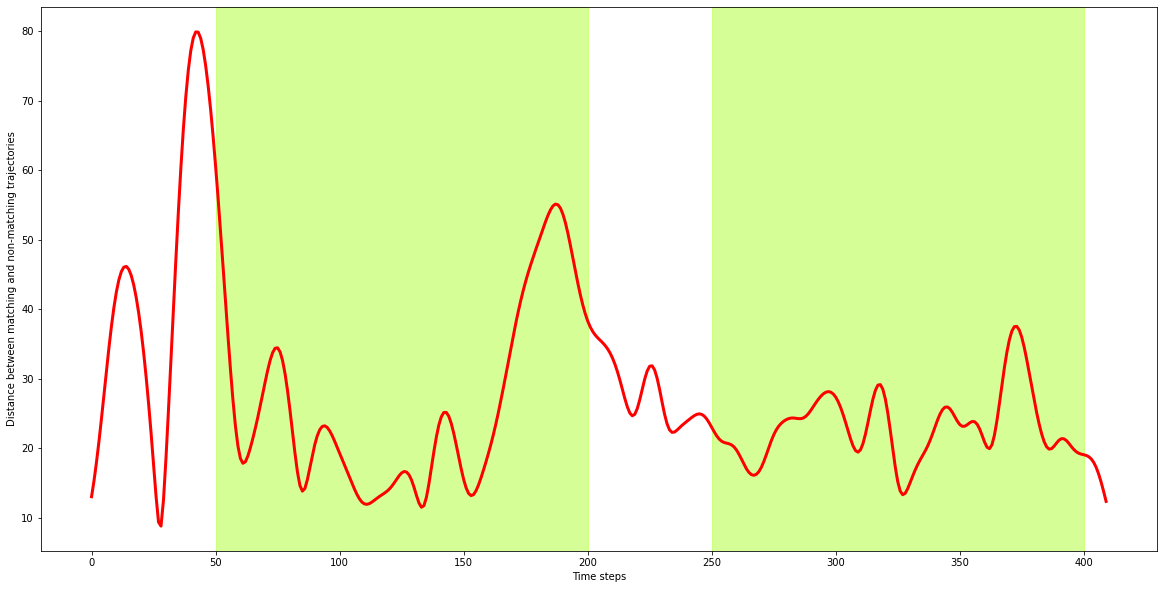

In [25]:
# PCA per trial type (matching vs. non-matching)
pca_global = PCA(n_components = 10)
pca_global_fit = pca_global.fit_transform(np.transpose(all_neurons) )
pca_matching = PCA(n_components = 10)
pca_matching_fit = pca_matching.fit_transform(np.transpose(matching_trials) )
pca_non_matching = PCA(n_components = 10)
pca_non_matching_fit = pca_non_matching.fit_transform(np.transpose(non_matching_trials) )

# some checks
print("Shape of pca_global object:", pca_global_fit.shape)
print("Shape of pca_matching object:", pca_matching_fit.shape)
print("Shape of pca_non_matching object:", pca_non_matching_fit.shape)

# retrieving coefficients from the global PCA (match and non-match data)
coeff_all = pca_global.components_.T

# projecting onto global (common) space
matching_trials_center = matching_trials - np.mean(matching_trials, axis = 0)[np.newaxis, :]
score1_global = np.dot(matching_trials_center.T, coeff_all)
non_matching_trials_center = non_matching_trials - np.mean(non_matching_trials, axis = 0)[np.newaxis, :]
score2_global = np.dot(non_matching_trials_center.T, coeff_all)

# computing the distance between matching and non-matching trajectories
distIn = np.sqrt(np.sum((score1_global - score2_global) ** 2, axis = 1) )

# retrieving the timing of the delay periods
start_first_delay = 0.5 / 0.01
end_first_delay = (0.5 + 1.5) / 0.01
start_second_delay = 2.5 / 0.01
end_second_delay = (2.5 + 1.5) / 0.01

# plotting it
fig, ax = plt.subplots(figsize = [20, 10])
plt.plot(distIn, 'r', linewidth = 3)
ax.axvspan(start_first_delay, end_first_delay, alpha = 0.5, color = "greenyellow")
ax.axvspan(start_second_delay, end_second_delay, alpha = 0.5, color = "greenyellow")
plt.xlabel("Time steps")
plt.ylabel("Distance between matching and non-matching trajectories")
plt.show()

In [38]:
score1_global.shape
pca_matching_fit.shape

(410, 10)

Start cue matching: 16.826 18.788 -7.746
Start cue non-matching: 18.607 25.628 0.135
Start first delay (blue): 9.102 20.675 -37.043
Start first delay (blue): -12.673 2.594 -22.685
Start sample (green): 3.588 -0.077 1.983
Start sample (green): -7.059 -8.406 24.99
Start second delay (orange): 11.815 11.723 48.046
Start second delay (orange): 9.337 6.407 33.963


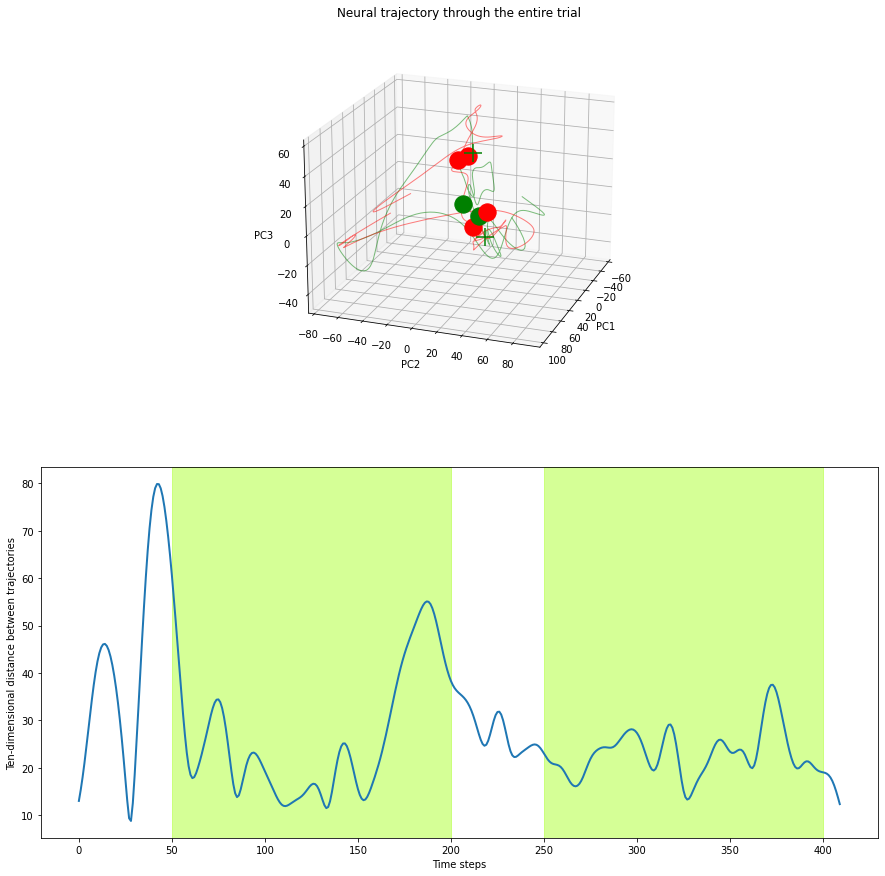

In [39]:
# 3D plot
# see also https://scikit-learn.org/stable/auto_examples/decomposition/plot_pca_iris.html#sphx-glr-auto-examples-decomposition-plot-pca-iris-py
from mpl_toolkits import mplot3d

# fig = plt.figure(figsize = (20, 10) )
# ax = plt.axes(projection = "3d")
# fig = plt.figure(figsize = plt.figaspect(2.) )
fig = plt.figure(figsize = (15, 15) )
ax = fig.add_subplot(2, 1, 1, projection = "3d")

# sc = ax.scatter(x_pca[:, 0], x_pca[:, 1], x_pca[:, 2], c = timepoints, cmap = colormap, s = 30, alpha = 0.5)
line = plt.plot(pca_matching_fit[:, 0], pca_matching_fit[:, 1], pca_matching_fit[:, 2], lw = 1, c = "green", alpha = 0.5)[0]
line = plt.plot(pca_non_matching_fit[:, 0], pca_non_matching_fit[:, 1], pca_non_matching_fit[:, 2], lw = 1, c = "red", alpha = 0.5)[0]
# line = plt.plot(score1_global[:, 0], score1_global[:, 1], score1_global[:, 2], lw = 1, c = "green", alpha = 0.5)[0]
# line = plt.plot(score2_global[:, 0], score2_global[:, 1], score2_global[:, 2], lw = 1, c = "red", alpha = 0.5)[0]

################################################################################
# plotting markers for periods changes within the trial
########################################################################

pca_matching_fit = score1_global
pca_non_matching_fit = score2_global

time_point = 0
ax.scatter(pca_matching_fit[time_point, 0], pca_matching_fit[time_point, 1], pca_matching_fit[time_point, 2], marker = "o", s = 300, c = "green")
print("Start cue matching:", round(pca_matching_fit[time_point, 0], 3), round(pca_matching_fit[time_point, 1], 3), round(x_pca[time_point, 2], 3) )
ax.scatter(pca_non_matching_fit[time_point, 0], pca_non_matching_fit[time_point, 1], pca_non_matching_fit[time_point, 2], marker = "o", s = 300, c = "red")
print("Start cue non-matching:", round(pca_non_matching_fit[time_point, 0], 3), round(pca_non_matching_fit[time_point, 1], 3), round(pca_non_matching_fit[time_point, 2], 3) )

time_point = int(0.5 / 0.01)
ax.scatter(pca_matching_fit[time_point, 0], pca_matching_fit[time_point, 1], pca_matching_fit[time_point, 2], marker = "+", s = 300, c = "green")
print("Start first delay (blue):", round(pca_matching_fit[time_point, 0], 3), round(pca_matching_fit[time_point, 1], 3), round(x_pca[time_point, 2], 3) )
ax.scatter(pca_non_matching_fit[time_point, 0], pca_non_matching_fit[time_point, 1], pca_non_matching_fit[time_point, 2], marker = "o", s = 300, c = "red")
print("Start first delay (blue):", round(pca_non_matching_fit[time_point, 0], 3), round(pca_non_matching_fit[time_point, 1], 3), round(pca_non_matching_fit[time_point, 2], 3) )

time_point = int(2 / 0.01)
ax.scatter(pca_matching_fit[time_point, 0], pca_matching_fit[time_point, 1], pca_matching_fit[time_point, 2], marker = "o", s = 300, c = "green")
print("Start sample (green):", round(pca_matching_fit[time_point, 0], 3), round(pca_matching_fit[time_point, 1], 3), round(x_pca[time_point, 2], 3) )
ax.scatter(pca_non_matching_fit[time_point, 0], pca_non_matching_fit[time_point, 1], pca_non_matching_fit[time_point, 2], marker = "o", s = 300, c = "red")
print("Start sample (green):", round(pca_non_matching_fit[time_point, 0], 3), round(pca_non_matching_fit[time_point, 1], 3), round(pca_non_matching_fit[time_point, 2], 3) )

time_point = int(2.5 / 0.01)
ax.scatter(pca_matching_fit[time_point, 0], pca_matching_fit[time_point, 1], pca_matching_fit[time_point, 2], marker = "+", s = 300, c = "green")
print("Start second delay (orange):", round(pca_matching_fit[time_point, 0], 3), round(pca_matching_fit[time_point, 1], 3), round(x_pca[time_point, 2], 3) )
ax.scatter(pca_non_matching_fit[time_point, 0], pca_non_matching_fit[time_point, 1], pca_non_matching_fit[time_point, 2], marker = "o", s = 300, c = "red")
print("Start second delay (orange):", round(pca_non_matching_fit[time_point, 0], 3), round(pca_non_matching_fit[time_point, 1], 3), round(pca_non_matching_fit[time_point, 2], 3) )

ax.view_init(20, 20, 0)
plt.colorbar(sc, label = "Timepoint")

ax.set_xlabel("PC1")
ax.set_ylabel("PC2")
ax.set_zlabel("PC3")
ax.set_title("Neural trajectory through the entire trial")

# computing the distance between matching and non-matching trajectories
distIn = np.sqrt(np.sum((pca_matching_fit - pca_non_matching_fit) ** 2, axis = 1) )

# retrieving the timing of the delay periods
start_first_delay = 0.5 / 0.01
end_first_delay = (0.5 + 1.5) / 0.01
start_second_delay = 2.5 / 0.01
end_second_delay = (2.5 + 1.5) / 0.01

# plotting it
# fig, ax = plt.subplots(figsize = [10, 5])
ax = fig.add_subplot(2, 1, 2)
plt.plot(distIn, linewidth = 2)
ax.axvspan(start_first_delay, end_first_delay, alpha = 0.5, color = "greenyellow")
ax.axvspan(start_second_delay, end_second_delay, alpha = 0.5, color = "greenyellow")
plt.xlabel("Time steps")
plt.ylabel("Ten-dimensional distance between trajectories")
plt.show()

plt.show()

/var/folders/yp/p14xyqpj5l3bnhqhhfk5qhqr0000gn/T/ipykernel_67529/2314086904.py:51: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colormap = cm.get_cmap("cool")
MovieWriter ffmpeg unavailable; using Pillow instead.
/var/folders/yp/p14xyqpj5l3bnhqhhfk5qhqr0000gn/T/ipykernel_67529/2314086904.py:26: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  scat1.set_data(matching_data[:2, num])
/var/folders/yp/p14xyqpj5l3bnhqhhfk5qhqr0000gn/T/ipykernel_67529/2314086904.py:28: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  scat2.set_data(non_matching_data[:2, num])


Start cue (red): 16.826 18.788 -3.969
Start first delay (blue): 9.102 20.675 -20.847
Start sample (green): 3.588 -0.077 -1.573
Start second delay (orange): 11.815 11.723 37.238


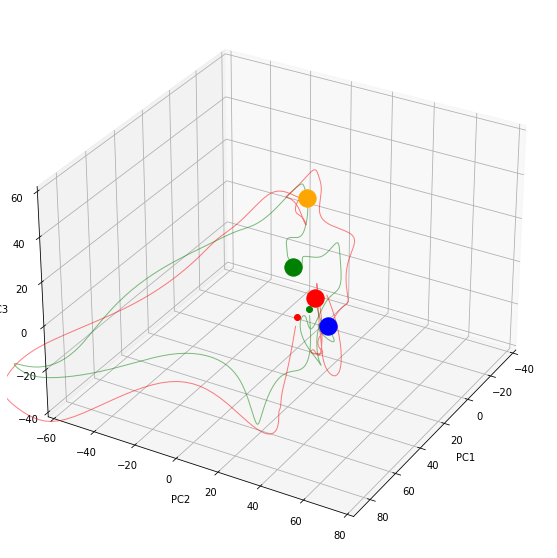

In [44]:
############################################################################################
# 3D plot animated version
# https://matplotlib.org/1.4.1/examples/animation/simple_3danim.html
# https://www.bragitoff.com/2020/10/3d-trajectory-animated-using-matplotlib-python/
# code from https://stackoverflow.com/questions/38118598/how-to-create-a-3d-animation
#########################################################################################

from mpl_toolkits.mplot3d import Axes3D
from matplotlib import animation

# retrieving the normalised PCA trajectories
pca_matching_fit = score1_global
pca_non_matching_fit = score2_global

# initialising the 3D plot
fig = plt.figure(figsize = (20, 10) )
ax = fig.add_subplot(projection = "3d")

def update(num, matching_data, non_matching_data, line1, line2, scat1, scat2):
    
    line1.set_data(matching_data[:2, :num])
    line1.set_3d_properties(matching_data[2, :num])
    line2.set_data(non_matching_data[:2, :num])
    line2.set_3d_properties(non_matching_data[2, :num])
    
    scat1.set_data(matching_data[:2, num])
    scat1.set_3d_properties(matching_data[2, num])
    scat2.set_data(non_matching_data[:2, num])
    scat2.set_3d_properties(non_matching_data[2, num])
    
    #if num >= int(0.5 / 0.01) and num < int(2 / 0.01):
    #    
    #    # line.set_color("black")
    #    scat.set_color("blue")
    #    
    #elif num >= int(2 / 0.01) and num < int(2.5 / 0.01):
    #    
    #    scat.set_color("green")
    #    
    #elif num >= int(2.5 / 0.01):
    #    
    #    scat.set_color("orange")

timepoints = np.arange(x_pca.shape[0])
matching_data = pca_matching_fit.T
non_matching_data = pca_non_matching_fit.T
N = data.shape[1]

# assigning colours to timepoints
# timepoints = np.arange(all_neurons.shape[1])
colormap = cm.get_cmap("cool")
norm = plt.Normalize(vmin = timepoints.min(), vmax = timepoints.max() )

line1, = ax.plot(matching_data[0, 0:1], matching_data[1, 0:1], matching_data[2, 0:1], lw = 1, c = "green", alpha = 0.5)
line2, = ax.plot(non_matching_data[0, 0:1], non_matching_data[1, 0:1], non_matching_data[2, 0:1], lw = 1, c = "red", alpha = 0.5)
scat1 = plt.plot(matching_data[0], matching_data[1], matching_data[2], lw = 2, c = "green", marker = "o")[0]
scat2 = plt.plot(non_matching_data[0], non_matching_data[1], non_matching_data[2], lw = 2, c = "red", marker = "o")[0]

# sc = ax.scatter(x_pca[:, 0], x_pca[:, 1], x_pca[:, 2], c = timepoints, cmap = colormap, s = 30, alpha = 0.5)
# line = plt.plot(pca_matching_fit[:, 0], pca_matching_fit[:, 1], pca_matching_fit[:, 2], lw = 1, c = "green", alpha = 0.5)[0]
# line = plt.plot(pca_non_matching_fit[:, 0], pca_non_matching_fit[:, 1], pca_non_matching_fit[:, 2], lw = 1, c = "red", alpha = 0.5)[0]
# line = plt.plot(score1_global[:, 0], score1_global[:, 1], score1_global[:, 2], lw = 1, c = "green", alpha = 0.5)[0]
# line = plt.plot(score2_global[:, 0], score2_global[:, 1], score2_global[:, 2], lw = 1, c = "red", alpha = 0.5)[0]

# scat = ax.scatter(data[0, 0:1], data[1, 0:1], data[2, 0:1])
# scat = plt.plot(data[0], data[1], data[2], lw = 2, c = timepoints[0], cmap = colormap, norm = norm, marker = "o")[0]

# plotting markers for periods changes within the trial
# cue onset
x_pca = matching_data.T
time_point = 0
ax.scatter(x_pca[time_point, 0], x_pca[time_point, 1], x_pca[time_point, 2], marker = "o", s = 300, c = "red")
print("Start cue (red):", round(x_pca[time_point, 0], 3), round(x_pca[time_point, 1], 3), round(x_pca[time_point, 2], 3) )

# first delay onset
time_point = int(0.5 / 0.01)
ax.scatter(x_pca[time_point, 0], x_pca[time_point, 1], x_pca[time_point, 2], marker = "o", s = 300, c = "blue")
print("Start first delay (blue):", round(x_pca[time_point, 0], 3), round(x_pca[time_point, 1], 3), round(x_pca[time_point, 2], 3) )

# sample onset
time_point = int(2 / 0.01)
ax.scatter(x_pca[time_point, 0], x_pca[time_point, 1], x_pca[time_point, 2], marker = "o", s = 300, c = "green")
print("Start sample (green):", round(x_pca[time_point, 0], 3), round(x_pca[time_point, 1], 3), round(x_pca[time_point, 2], 3) )

# second delay onset
time_point = int(2.5 / 0.01)
ax.scatter(x_pca[time_point, 0], x_pca[time_point, 1], x_pca[time_point, 2], marker = "o", s = 300, c = "orange")
print("Start second delay (orange):", round(x_pca[time_point, 0], 3), round(x_pca[time_point, 1], 3), round(x_pca[time_point, 2], 3) )

# setting the viewing angle
ax.view_init(30, 30, 0)

# setting the axes properties
ax.set(xlim3d = (-40, 90), xlabel = "PC1")
ax.set(ylim3d = (-60, 80), ylabel = "PC2")
ax.set(zlim3d = (-40, 60), zlabel = "PC3")

# animating the plot
ani = animation.FuncAnimation(fig, update, N, fargs = (matching_data, non_matching_data, line1, line2, scat1, scat2), interval = 20, blit = False)

# saving/exporting it
ani.save("animated_3d_pca.gif")

# showing it
plt.show()

# Temporal decoding
## Step 1: Reshaping the data (without averaging trials)

See https://mne.tools/stable/auto_tutorials/machine-learning/50_decoding.html#decoding-over-time)

Number of unique trials: 481


(array([147.,  56.,  14.,  19.,   6.,   4.,   5.,   4.,   2.,   3.,   2.,
          5.,   4.,   5.,   5.,   7.,   5.,   8.,   6.,   2.,   4.,   6.,
          5.,   3.,   3.,   3.,   6.,   3.,   2.,   2.,   4.,   4.,   6.,
         14.,  14.,  24.,  31.,  28.,   6.,   4.]),
 array([   2.   ,   43.325,   84.65 ,  125.975,  167.3  ,  208.625,
         249.95 ,  291.275,  332.6  ,  373.925,  415.25 ,  456.575,
         497.9  ,  539.225,  580.55 ,  621.875,  663.2  ,  704.525,
         745.85 ,  787.175,  828.5  ,  869.825,  911.15 ,  952.475,
         993.8  , 1035.125, 1076.45 , 1117.775, 1159.1  , 1200.425,
        1241.75 , 1283.075, 1324.4  , 1365.725, 1407.05 , 1448.375,
        1489.7  , 1531.025, 1572.35 , 1613.675, 1655.   ]),
 <BarContainer object of 40 artists>)

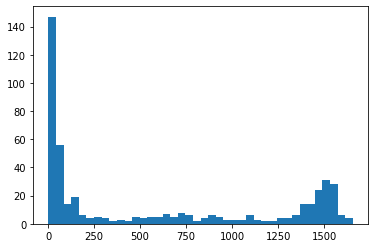

In [224]:
# NB: in the end we'll try using all matching vs. all non-matching trials
# number of available trials
print("Number of unique trials:", len(np.unique(df.trialnum) ) )

# number of observations per trial (neurons)
# print(df.trialnum.value_counts().head(50) )

# sorting by trial number
# df_NOI.sort_values("trialnum").head(20)

# plotting an histogram of that
plt.hist(df.trialnum.value_counts(), bins = 40)

In [194]:
# listing filename that contain the most trials
# print(df.query('Training == "POST"').Filename.value_counts().head(50) )

# listing the number of trials per neuron in these filename
print(df.query('Filename == "Elv188_1"').Neuron.value_counts() )
print(df.query('Filename in ("Elv188_1", "Elv191_1")').Neuron.value_counts() )
print(df.query('Filename in ("Elv188_1", "Elv191_1", "Elv192_1")').Neuron.value_counts() )

Neuron
5026    180
5027    180
5028    180
5029    180
5030    180
5031    180
5032    180
5033    180
5034    180
5035    180
5036    180
5037    180
5038    180
Name: count, dtype: int64
Neuron
5026    180
5033    180
5027    180
5038    180
5036    180
5035    180
5034    180
5037    180
5032    180
5031    180
5030    180
5029    180
5028    180
5077    108
5086    108
5085    108
5084    108
5083    108
5082    108
5080    108
5079    108
5078    108
5071    108
5076    108
5075    108
5074    108
5073    108
5072    108
5070    108
5069    108
5068    108
5067    108
5087    108
5081    104
Name: count, dtype: int64
Neuron
5026    180
5033    180
5027    180
5038    180
5037    180
5035    180
5034    180
5036    180
5032    180
5031    180
5030    180
5029    180
5028    180
5097    108
5089    108
5090    108
5091    108
5092    108
5093    108
5094    108
5095    108
5104    108
5098    108
5100    108
5101    108
5102    108
5103    108
5087    108
5105    108
5106    108
510

In [225]:
# keeping only one recording session for the decoding
# df_decoding = df.query('Filename in ("Elv191_1", "Elv192_1") & Neuron != 5081 & Neuron != 5096')
df_decoding = df.query('Filename == "Elv188_1"')
# df_decoding =df.query('Filename in ("Elv188_1", "Elv191_1", "Elv192_1")')
print(df_decoding.shape)
print(df_decoding.head(10) )
# df_decoding.Neuron.value_counts()

(2340, 13)
        Filename  Neuron     Task Training    Area  Cue_position   Cue_onT   
224275  Elv188_1    5026  SPATIAL     POST  dorsal             1  1.061825  \
224276  Elv188_1    5026  SPATIAL     POST  dorsal             1  1.069050   
224277  Elv188_1    5026  SPATIAL     POST  dorsal             1  1.073675   
224278  Elv188_1    5026  SPATIAL     POST  dorsal             1  1.267175   
224279  Elv188_1    5026  SPATIAL     POST  dorsal             1  1.064375   
224280  Elv188_1    5026  SPATIAL     POST  dorsal             1  1.074725   
224281  Elv188_1    5026  SPATIAL     POST  dorsal             1  1.065650   
224282  Elv188_1    5026  SPATIAL     POST  dorsal             1  1.076025   
224283  Elv188_1    5026  SPATIAL     POST  dorsal             1  1.064275   
224284  Elv188_1    5026  SPATIAL     POST  dorsal             1  1.062375   

        Sample_onT  Target_onT  Reward_onT  trialnum  IsMatch monkey  
224275    3.096050    5.130275    5.980625        20      0

In [226]:
# converting dataframe to numpy arrays
training = df.Training.to_numpy()
filename = df.Filename.to_numpy()
neuronID = df.Neuron.to_numpy()
monkey = df.monkey.to_numpy()
reward = df.Reward_onT.to_numpy()

# extract neurons of interst
elv_monkey = monkey == "ELV"
postTrainTrials = training == "POST"
reward_not_nan = np.isnan(reward) == False
# decoding_filename = filename == "Elv192_1" # "ELV051_1"
# decoding_filename = np.isin(filename, ("Elv188_1", "Elv191_1", "Elv192_1") ) # == False
decoding_filename = filename == "Elv188_1"
kept_neurons = np.isin(neuronID, (5081, 5096) ) == False

# lines of interest in the data (focusing on post-training data and the ELV monkey)
# lines_decoding = postTrainTrials & elv_monkey & reward_not_nan & kept_neurons & decoding_filename
lines_decoding = postTrainTrials & elv_monkey & reward_not_nan & decoding_filename

# filtering the data
ts_decoding = TS[lines_decoding]

# filtering neurons
neuronID_NOI = np.unique(neuronID[lines_decoding])
neuronNum = len(np.unique(lines_decoding) )

# excluding trials without reward
# np.isnan()

# number of available lines (neurons * trials)
print("Number of available lines (neurons x trials):", ts_decoding.shape[0])

# number of available neurons
print("Number of available neurons:", neuronID_NOI.shape[0])

Number of available lines (neurons x trials): 2340
Number of available neurons: 13


In [228]:
####################################################################################
# retrieving all trials for all neurons and averaging (not averaged)
#############################################################################

# df_NOI = df_decoding
# TS_NOI = ts_decoding

# listing all neurons for ELV
elv_neurons = np.unique(df_decoding["Neuron"].to_numpy() )

# initialising the neurons array
max_time_steps = 410
# all_neurons_raw = np.empty((len(elv_neurons) * df_NOI.shape[0], max_time_steps) )
# all_neurons_raw = np.empty((len(elv_neurons) * 100, max_time_steps) )
all_neurons_raw = np.empty((df_decoding.shape[0], max_time_steps) )

# initialising the row counter
neuron_row = 0

# initialising the labels
labels = []

# initialising the trial numbers
# trial_numbers = []
    
for neuron in elv_neurons:
    
    # printing neuron progress
    print("Processing neuron:", neuron)
    
    # finding all trials for this neuron
    # WARNING: some trials are duplicated and should be then removed
    df_neuron = df_decoding.query("Neuron == " + str(neuron) )
    df_neuron = df_neuron.drop_duplicates(subset = "trialnum", keep = "first")
    neuron_rows = df_decoding.index.get_indexer(df_neuron.index)
    
    # printing number of trials for this particular neuron
    print("Number of available trials:", len(neuron_rows) )
    
    # retrieving all trials for this neuron
    spike_times = ts_decoding[neuron_rows]
    
    # initialising empty list for trials
    spike_trains = np.empty((spike_times.shape[0], max_time_steps) )
    
    # for trial in range(spike_times.shape[0]):
    for trial in range(100):
        
        # printing trial progress
        # print("Trial: ", trial)
        
        # if there is no spike in this trial
        if np.sum(spike_times[trial][0]) == 0:
            
            spike_train = [0] * max_time_steps
            
        else: 
        
            # retrieving spiking times for this trial
            this_trial_spikes_train = spike_times[trial][0][0]
            
            # retrieving trial information
            this_neuron_trialnum = np.unique(df_neuron["trialnum"].to_numpy() )
            this_trial_start_cue = np.round(df_neuron.query("trialnum == " + str(this_neuron_trialnum[trial]) )["Cue_onT"].to_numpy()[0], 3)
            this_trial_start_target = np.round(df_neuron.query("trialnum == " + str(this_neuron_trialnum[trial]) )["Target_onT"].to_numpy()[0], 3)
            spike_train = np.array(spike_times_to_spike_trains(this_trial_spikes_train, start_cue = this_trial_start_cue, start_target = this_trial_start_target) )
            if spike_train.shape[0] < 410: spike_train.resize(410, refcheck = False)
            
            # retrieving the match/non-match status of this trial
            # this_trial_match = df_neuron.query("trialnum == " + str(this_neuron_trialnum[trial]) )["IsMatch"].to_numpy()[0]
        
            # print(this_trial_start_cue, this_trial_start_target)
            # print(spike_train)
        
            # print("Length of current spike train:", spike_train.shape)
        
        # np.append(spike_trains, spike_train, axis = 0)
        # np.vstack((spike_trains, spike_train) )
        # spike_trains[trial, :] = spike_train
        
        # smoothing the spike trains per trial before averaging
        smoothed_spike_train = kernel_smooth_spike_data(this_trial_spikes_train, time_range = [np.min(this_trial_spikes_train), np.max(this_trial_spikes_train)], num_points = max_time_steps)
        spike_trains[trial, :] = smoothed_spike_train
    
    # print(spike_trains[0])
    # print(type(spike_train))
    # print(len(spike_trains) )
    # spike_trains = np.array(spike_trains)
    print("Shape of spiking times array (trial x time steps)", spike_trains.shape)
    
    # averaging these data
    # to-do: averaging per match/non-match
    # averaged_neuron_spikes = np.mean(spike_trains, axis = 0)
    
    # appending data
    # all_neurons.append(averaged_neuron_spikes)
    # np.vstack((all_neurons, averaged_neuron_spikes) )
    # all_neurons[neuron_row, :] = averaged_neuron_spikes
    # spike_trains.shape[0]
    
    # appending data (all trials)
    # all_neurons_raw[neuron_row:neuron_row+spike_trains.shape[0], :] = spike_trains
    
    # or keeping only the first ten trials (for decoding)
    # spike_trains = spike_trains[0:10]
    spike_trains = spike_trains
    all_neurons_raw[neuron_row:neuron_row+spike_trains.shape[0], :] = spike_trains
    
    # appending the labels
    # labels.append(df_neuron["IsMatch"].to_numpy()[0:10])
    labels.append(df_neuron["IsMatch"].to_numpy() )
    
    # appending the trial number
    # trial_numbers.append(this_neuron_trialnum)
    
    # incrementing the row counter
    # neuron_row += 1
    neuron_row += spike_trains.shape[0]

Processing neuron: 5026
Number of available trials: 180
Shape of spiking times array (trial x time steps) (180, 410)
Processing neuron: 5027
Number of available trials: 180
Shape of spiking times array (trial x time steps) (180, 410)
Processing neuron: 5028
Number of available trials: 180
Shape of spiking times array (trial x time steps) (180, 410)
Processing neuron: 5029
Number of available trials: 180
Shape of spiking times array (trial x time steps) (180, 410)
Processing neuron: 5030
Number of available trials: 180
Shape of spiking times array (trial x time steps) (180, 410)
Processing neuron: 5031
Number of available trials: 180
Shape of spiking times array (trial x time steps) (180, 410)
Processing neuron: 5032
Number of available trials: 180
Shape of spiking times array (trial x time steps) (180, 410)
Processing neuron: 5033
Number of available trials: 180
Shape of spiking times array (trial x time steps) (180, 410)
Processing neuron: 5034
Number of available trials: 180
Shape of

In [229]:
# some sanity checks
print("Shape of the raw array:", all_neurons_raw.shape)

# same labels (or not)?
print("Shape of the labels' list", len(labels) )

Shape of the raw array: (2340, 410)
Shape of the labels' list 13


(array([  3.,   0.,  10.,  20., 412.,   3., 155.,   4., 188.,   3.]),
 array([ 36. ,  52.3,  68.6,  84.9, 101.2, 117.5, 133.8, 150.1, 166.4,
        182.7, 199. ]),
 <BarContainer object of 10 artists>)

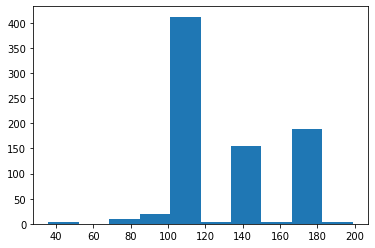

In [24]:
# compute the number of trials per neuron
df_NOI.Neuron.value_counts()
plt.hist(df_NOI.Neuron.value_counts() )

In [9]:
# find neurons with less than 100 trials
neurons_trials = df_NOI.Neuron.value_counts()
print(neurons_trials[neurons_trials >= 100])
neurons_to_keep = neurons_trials[neurons_trials >= 100].index.to_numpy()

# identifying the lines related to these neurons
neuronID = df_NOI.Neuron.to_numpy()
neurons_to_keep_lines = np.isin(neuronID, neurons_to_keep)

# filtering the data
# df_decoding = df_NOI[neurons_to_keep_lines]
df_decoding = df_NOI.loc[neurons_to_keep_lines]
ts_decoding = TS_NOI[neurons_to_keep_lines]

# sanity check
print("These shapes should be similar:", df_decoding.shape, ts_decoding.shape)

Neuron
2111    199
2106    199
2105    199
2001    180
2205    180
       ... 
2108    103
2109    103
2107    103
5120    102
5320    102
Name: count, Length: 765, dtype: int64
These shapes should be similar: (102086, 13) (102086, 1)


In [172]:
####################################################################################
# retrieving all trials for all neurons and averaging across trials
# general average plus averge per trial type (matching vs. non-matching)
###############################################################################

# WARNING: some (few) trials are duplicated and should be then removed
# df_decoding2 = df_decoding.drop_duplicates(subset = "trialnum", keep = "first")
# df_decoding2 = df_decoding.drop_duplicates(subset = ("Neuron", "trialnum"), keep = "first")
lines_to_keep = df_decoding.duplicated(subset = ("Neuron", "trialnum"), keep = "first") == False
df_decoding = df_decoding.loc[lines_to_keep]
ts_decoding = ts_decoding[lines_to_keep]

# listing all neurons for ELV
elv_neurons = np.unique(df_decoding["Neuron"].to_numpy() )

# defining the desired number of time steps
max_time_steps = 410

# computing the total number of matching and non-matching trials
n_matching = df_decoding.IsMatch.value_counts()[1]
n_non_matching = df_decoding.IsMatch.value_counts()[0]

# initialising the matching and non-matching arrays
matching_trials_raw = np.empty((n_matching, len(elv_neurons), max_time_steps) )
non_matching_trials_raw = np.empty((n_non_matching, len(elv_neurons), max_time_steps) )
all_neurons_raw = np.empty((n_matching+n_non_matching, len(elv_neurons), max_time_steps) )

# initialising the rows and cols counters
# neuron_row = 0
# neuron_col_matching = 0
# neuron_col_non_matching = 0
neuron_col = 0
trial_row_matching = 0
trial_row_non_matching = 0

for neuron in elv_neurons: # for each neuron
    
    # printing neuron progress
    print("Processing neuron:", neuron, "(i.e., neuron number", neuron_col + 1, "out of", len(elv_neurons), "neurons).")
    
    # finding all trials for this neuron
    # WARNING: some (few) trials are duplicated and should be then removed
    df_neuron = df_decoding.query("Neuron == " + str(neuron) )
    # df_neuron = df_neuron.drop_duplicates(subset = "trialnum", keep = "first")
    neuron_rows = df_decoding.index.get_indexer(df_neuron.index)
    
    # printing the number of trials for this particular neuron
    print("Number of available trials:", len(neuron_rows) )
    
    # retrieving all trials for this neuron
    spike_times = ts_decoding[neuron_rows]
    
    # retrieving the number of matching and non-matching trials
    this_neuron_match = df_neuron["IsMatch"].to_numpy()
    this_neuron_n_matching = np.sum(this_neuron_match == 1)
    this_neuron_n_non_matching = np.sum(this_neuron_match == 0)
    
    # printing progress
    print("Found", this_neuron_n_matching, "matching and", this_neuron_n_non_matching, "non-matching trials for this neuron.")
    
    # initialising empty list for trials
    spike_trains_non_matching = np.empty((this_neuron_n_non_matching, max_time_steps) )
    spike_trains_matching = np.empty((this_neuron_n_matching, max_time_steps) )
    this_neuron_all_trials = np.empty((len(neuron_rows), max_time_steps) )
    
    # initialising row counts
    this_neuron_non_matching_trial_row = 0
    this_neuron_matching_trial_row = this_neuron_n_non_matching - 1
    
    for trial in range(len(neuron_rows) ): # for each trial
    # for trial in range(80): # for each trial (up to 80)
        
        # printing trial progress
        # print("Trial: ", trial)
        
        # if there is no spike in this trial
        if np.sum(spike_times[trial][0]) == 0:
            
            # filling-in with zeros
            spike_train = [0] * max_time_steps
            
        else: 
        
            # retrieving spiking times for this trial
            this_trial_spikes_train = spike_times[trial][0][0]
            
            # retrieving the trials numbers
            this_neuron_trialnum = np.unique(df_neuron["trialnum"].to_numpy() )
            this_trial_trialnum = this_neuron_trialnum[trial]
            this_trial_start_cue = np.round(df_neuron.query("trialnum == " + str(this_trial_trialnum) )["Cue_onT"].to_numpy()[0], 3)
            this_trial_start_target = np.round(df_neuron.query("trialnum == " + str(this_trial_trialnum) )["Target_onT"].to_numpy()[0], 3)
            
            # retrieving the spike train for this trial
            spike_train = np.array(spike_times_to_spike_trains(this_trial_spikes_train, start_cue = this_trial_start_cue, start_target = this_trial_start_target) )
            if spike_train.shape[0] < 410: spike_train.resize(410, refcheck = False)
            
            # retrieving the match/non-match status for this neuron and for this trial
            # this_neuron_match = df_neuron["IsMatch"].to_numpy()
            this_trial_match = df_neuron.query("trialnum == " + str(this_trial_trialnum) )["IsMatch"].to_numpy()[0]
        
        # np.append(spike_trains, spike_train, axis = 0)
        # np.vstack((spike_trains, spike_train) )
        # spike_trains[trial, :] = spike_train
        
        # smoothing the spike trains per trial before averaging
        smoothed_spike_train = kernel_smooth_spike_data(this_trial_spikes_train, time_range = [np.min(this_trial_spikes_train), np.max(this_trial_spikes_train)], num_points = max_time_steps)
        
        # printing for monitoring
        # print(this_neuron_matching_trial_row, this_neuron_non_matching_trial_row)
        
        # storing this spike train in the first lines of this_neuron_all_trials if it was a non-matching trial
        if this_trial_match == 0:
            
            # spike_trains_non_matching[trial, :] = smoothed_spike_train
            this_neuron_all_trials[this_neuron_non_matching_trial_row, :] = smoothed_spike_train
            this_neuron_non_matching_trial_row += 1
            
        # storing this spike train in the last lines of this_neuron_all_trials if it was a matching trial
        elif this_trial_match == 1:
            
            # spike_trains_matching[trial, :] = smoothed_spike_train
            this_neuron_all_trials[this_neuron_matching_trial_row, :] = smoothed_spike_train
            this_neuron_matching_trial_row += 1
            
        # if there are more trials than expected (additional duplicated trials?), then break the current for loop and go to next neuron
        if this_neuron_matching_trial_row >= this_neuron_all_trials.shape[0]: break
    
    # or keeping only the first ten trials (for decoding)
    # spike_trains = spike_trains[0:10]
    # spike_trains = spike_trains
    # all_neurons_raw[neuron_row:neuron_row+spike_trains.shape[0], :] = spike_trains
    # matching_trials_raw[neuron_row:neuron_row+spike_trains[this_neuron_match == 1, :].shape[0], :] = spike_trains[this_neuron_match == 1, :]
    # non_matching_trials_raw[neuron_row:neuron_row+spike_trains[this_neuron_match == 0, :].shape[0], :] = spike_trains[this_neuron_match == 0, :]
    
    # all_neurons_raw[trial_row_matching:trial_row_matching+spike_trains_matching.shape[0], neuron_col, :] = spike_trains_matching
    # all_neurons_raw[trial_row_non_matching+n_non_matching:trial_row_non_matching+n_non_matching+spike_trains_non_matching.shape[0], neuron_col, :] = spike_trains_non_matching
    
    all_neurons_raw[trial_row_matching+n_non_matching:trial_row_matching+n_non_matching+this_neuron_n_matching, neuron_col, :] = this_neuron_all_trials[this_neuron_n_non_matching:, :]
    all_neurons_raw[trial_row_non_matching:trial_row_non_matching+this_neuron_n_non_matching, neuron_col, :] = this_neuron_all_trials[:this_neuron_n_non_matching, :]
    
    print("Writing in rows:", trial_row_non_matching, "to", trial_row_non_matching+this_neuron_n_non_matching)
    print("And:", trial_row_matching+n_non_matching, "to", trial_row_matching+n_non_matching+this_neuron_n_matching)
    
    # matching_trials_raw[trial_row_matching:trial_row_matching+spike_trains_matching.shape[0], neuron_row, :] = spike_trains_matching
    # non_matching_trials_raw[trial_row_non_matching:trial_row_non_matching+spike_trains_non_matching.shape[0], neuron_row, :] = spike_trains_non_matching
    
    # incrementing the rows and conlumns counters
    trial_row_non_matching += this_neuron_n_non_matching
    trial_row_matching += this_neuron_n_matching
    # neuron_col_matching += 1
    # neuron_col_non_matching += 1
    neuron_col +=1

Processing neuron: 2001 (i.e., neuron number 1 out of 765 neurons).
Number of available trials: 180
Found 90 matching and  90 non-matching trials for this neuron.
Writing in rows: 0 to 90
And: 50967 to 51057
Processing neuron: 2002 (i.e., neuron number 2 out of 765 neurons).
Number of available trials: 180
Found 90 matching and  90 non-matching trials for this neuron.
Writing in rows: 90 to 180
And: 51057 to 51147
Processing neuron: 2003 (i.e., neuron number 3 out of 765 neurons).
Number of available trials: 180
Found 90 matching and  90 non-matching trials for this neuron.
Writing in rows: 180 to 270
And: 51147 to 51237
Processing neuron: 2004 (i.e., neuron number 4 out of 765 neurons).
Number of available trials: 180
Found 90 matching and  90 non-matching trials for this neuron.
Writing in rows: 270 to 360
And: 51237 to 51327
Processing neuron: 2006 (i.e., neuron number 5 out of 765 neurons).
Number of available trials: 180
Found 90 matching and  90 non-matching trials for this neuro

In [177]:
# some sanity checks
print("Shape of the entire raw array:", all_neurons_raw.shape)
# print("Shape of the matchin raw array:", matching_trials_raw.shape)
# print("Shape of the non-matching raw array:", non_matching_trials_raw.shape)

# same labels (or not)?
# print("Shape of the labels' list", len(labels) )

# labels2 = np.hstack(labels)
# labels2 = np.concatenate([np.array(i) for i in labels])

# combining the matching and non-matching trials
# X = np.vstack((non_matching_trials_raw, matching_trials_raw) )
# X = np.concatenate([non_matching_trials_raw, matching_trials_raw])
# solution from https://stackoverflow.com/questions/67185154/numpy-concatenate-function-causes-jupyter-kernel-to-die
# empty_list = []
# empty_list.extend(non_matching_trials_raw)
# empty_list.extend(matching_trials_raw)
# X = np.array(empty_list)
# print("Shape of X", X.shape)

# creating a series of labels
labels = [0] * non_matching_trials_raw.shape[0] + [1] * matching_trials_raw.shape[0]
print("Shape of the labels' list", len(labels) )

Shape of the entire raw array: (101903, 765, 410)
Shape of the labels' list 101903


In [ ]:
# removing zero elements
# non_zero_lines = all_neurons_raw.nonzero()
# elems = all_neurons_raw[non_zero_lines]
# print("Shape of the entire raw array:", elems.shape)

# creating a series of labels
# labels2 = labels[non_zero_lines]
# print("Shape of the labels' list", len(labels2) )

In [138]:
# size of propspective 3D numpy array (in gb)
nbites = len(labels) * matching_trials_raw.shape[1] * matching_trials_raw.shape[2] * 8
nbites / 1000000000

255.6950076

In [ ]:
# creating a memory-mapped array in write mode:
# nrows, ncols, nthird = len(labels), matching_trials_raw.shape[1], matching_trials_raw.shape[2]
# f = np.memmap("memmapped.dat", dtype = np.float32, mode = "w+", shape = (nrows, ncols, nthird) )
# f = np.concatenate([non_matching_trials_raw, matching_trials_raw])
# f = np.memmap('memmapped.dat', dtype=np.float32, shape=(nrows, ncols))

In [230]:
# shuffling the rows of boths X and the labels in unison and limiting the size of the data for efficiency (only 10%)
# randomize = np.arange(len(x))
# np.random.shuffle(randomize)
# x = x[randomize]
# y = y[randomize]

from sklearn.utils import shuffle
# X, y = shuffle(all_neurons_raw[[0:500, n_non_matching:n_non_matching+500], :, :], labels[[0:500, n_non_matching:n_non_matching+500]], random_state = 0)
# X, y = shuffle(all_neurons_raw[100::100, :, :], labels[100::100], random_state = 0)
X = all_neurons_raw[100::100, :, :]
y = labels[100::100]
print(X.shape, len(y) )

IndexError: too many indices for array: array is 2-dimensional, but 3 were indexed

In [232]:
# old reshape method
X = all_neurons_raw.reshape((len(labels[0]), len(elv_neurons), all_neurons_raw.shape[1]) )
y = labels[0]

## Step 2: Actual temporal decoding

In [ ]:
# training the classifier on matching vs. non-matching trials
clf = make_pipeline(StandardScaler(), LogisticRegression(solver = "liblinear") )
time_decod = SlidingEstimator(clf, n_jobs = None, scoring = "roc_auc", verbose = True)

# computing the cross-validated accuracy
# scores = cross_val_multiscore(time_decod, X, y, cv = 4, n_jobs = 4)
scores = cross_val_multiscore(time_decod, X, y, cv = 8, n_jobs = None)

# mean scores across cross-validation splits
scores = np.mean(scores, axis = 0)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


  0%|          | Fitting SlidingEstimator : 0/410 [00:00<?,       ?it/s]

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.5s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.5s finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.4s remaining:    0.0s


  0%|          | Fitting SlidingEstimator : 0/410 [00:00<?,       ?it/s]

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.5s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.5s finished
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    2.7s remaining:    0.0s


  0%|          | Fitting SlidingEstimator : 0/410 [00:00<?,       ?it/s]

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.5s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.5s finished
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    4.1s remaining:    0.0s


  0%|          | Fitting SlidingEstimator : 0/410 [00:00<?,       ?it/s]

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.5s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.5s finished
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    5.5s remaining:    0.0s


  0%|          | Fitting SlidingEstimator : 0/410 [00:00<?,       ?it/s]

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.5s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.5s finished


  0%|          | Fitting SlidingEstimator : 0/410 [00:00<?,       ?it/s]

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Text(0.5, 1.0, 'Sensor space decoding')

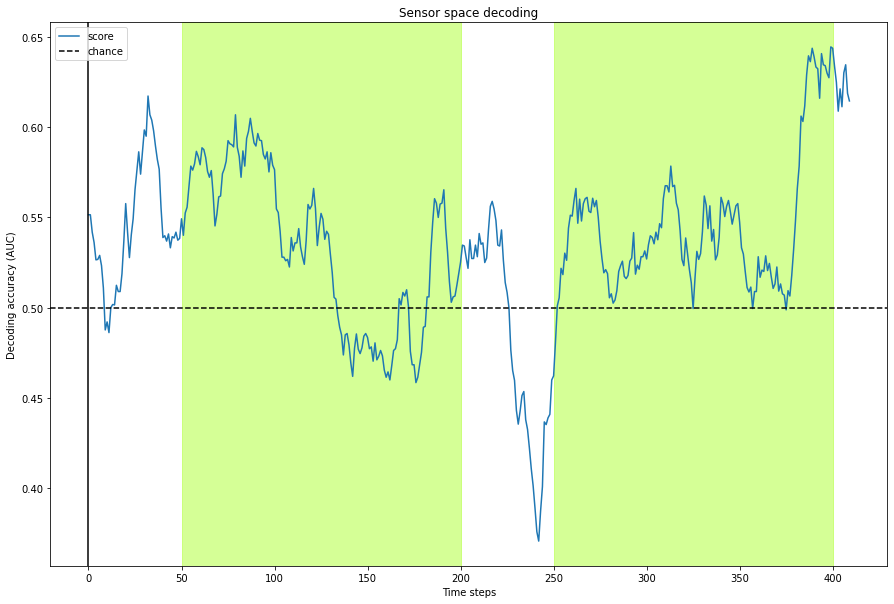

In [234]:
# defining the two periods of interest (delay 1 and delay 2)
start_first_delay = 0.5 / 0.01
end_first_delay = (0.5 + 1.5) / 0.01
start_second_delay = 2.5 / 0.01
end_second_delay = (2.5 + 1.5) / 0.01

# plotting decoding accuracy over time
fig, ax = plt.subplots(figsize = [15, 10])
fig.savefig(fname = "figures/temporal_decoding.png", dpi = 200)
ax.axvspan(start_first_delay, end_first_delay, alpha = 0.5, color = "greenyellow")
ax.axvspan(start_second_delay, end_second_delay, alpha = 0.5, color = "greenyellow")
ax.plot(np.arange(len(scores) ), scores, label = "score")
ax.axhline(0.5, color = "k", linestyle = "--", label  ="chance")
ax.set_xlabel("Time steps")
ax.set_ylabel("Decoding accuracy (AUC)")
ax.legend()
ax.axvline(0.0, color = "k", linestyle = "-")
ax.set_title("Sensor space decoding")

In [312]:
# defining the temporal generalization object
time_gen = GeneralizingEstimator(clf, n_jobs = 4, scoring = "roc_auc", verbose = True)

# computing the cross-validated score (this can take a while to run...)
scores = cross_val_multiscore(time_gen, X, y, cv = 4, n_jobs = 4)

# mean scores across cross-validation splits
scores = np.mean(scores, axis = 0)

Text(0.5, 1.0, 'Decoding MEG sensors over time')

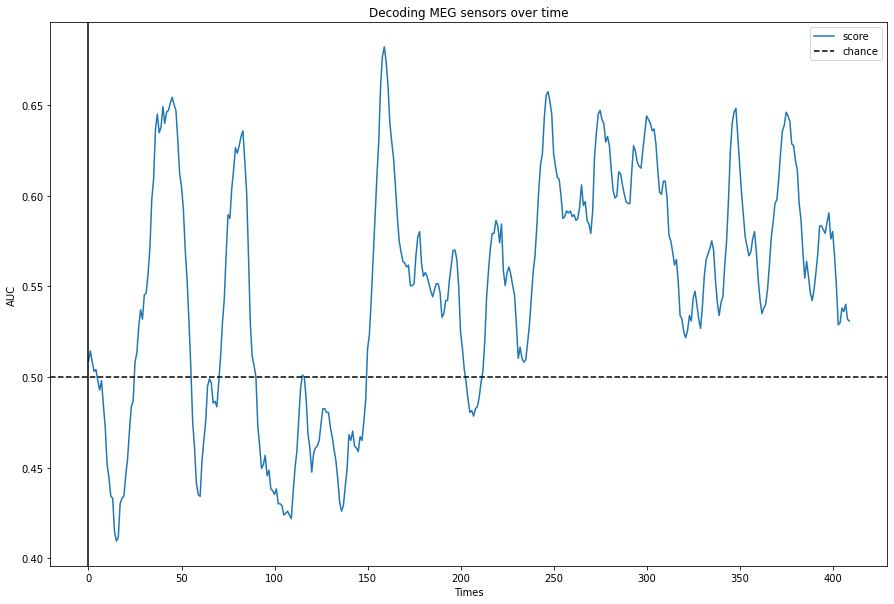

In [325]:
# plotting the diagonal (it's exactly the same as the time-by-time decoding above)
fig, ax = plt.subplots(figsize = [15, 10])
ax.plot(np.arange(len(scores) ), np.diag(scores), label = "score")
ax.axhline(0.5, color = "k", linestyle = "--", label = "chance")
ax.set_xlabel("Time steps")
ax.set_ylabel("Decoding accuracy (AUC)")
ax.legend()
ax.axvline(0.0, color = "k", linestyle = "-")
ax.set_title("Decoding MEG sensors over time")

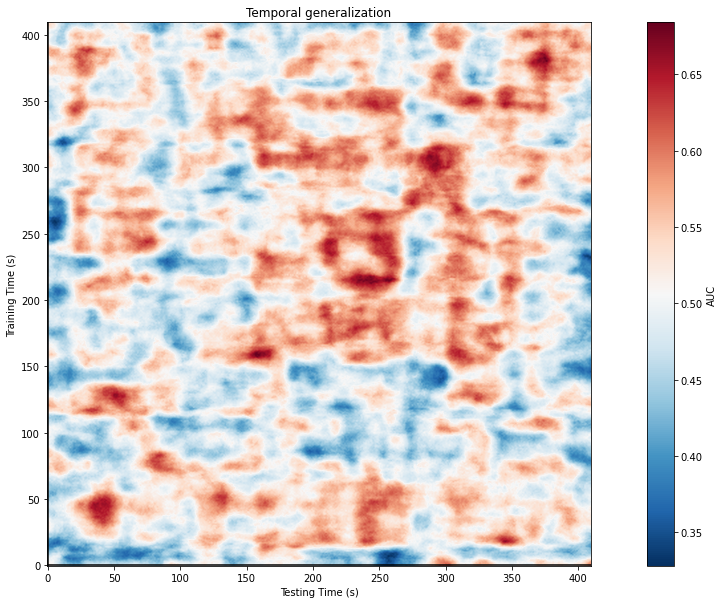

In [330]:
# plotting the full temporal generalisation matrix
fig, ax = plt.subplots(figsize = [20, 10])

im = ax.imshow(
    scores,
    interpolation = "lanczos",
    origin = "lower",
    cmap = "RdBu_r",
    # extent = epochs.times[[0, -1, 0, -1]],
    # extent = np.arange(len(scores) ),
    # vmin = 0.0,
    # vmax = 1.0,
    )

ax.set_xlabel("Testing Time (s)")
ax.set_ylabel("Training Time (s)")
ax.set_title("Temporal generalization")
ax.axvline(0, color="k")
ax.axhline(0, color="k")
cbar = plt.colorbar(im, ax = ax)
cbar.set_label("AUC")